# 0. Setup e importazione

In [143]:
# base
import os
import json
import pandas as pd
import pprint
import seaborn as sns
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
import statistics

# nlp
import re
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

# download

# Scarica il corpus delle stopwords inglesi
nltk.download('stopwords')
# Ottieni la lista delle stopwords inglesi
stop_words_en = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giorg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giorg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giorg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
files = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk("Dataset_TLDRHQ/") for f in filenames]
#files = files[0:100] # subset composed of train, val, test

test = pd.DataFrame()
train = pd.DataFrame()
val = pd.DataFrame()

for file in files:
    temp = pd.read_json(file, lines=True)
    temp.set_index("id", inplace=True)
        
    if "test" in file:
        test = pd.concat([test, temp])
    if "train" in file:
        train = pd.concat([train, temp])
    else:
        val = pd.concat([val, temp])
    
corpus = {'train': train,
              'val': val,
                'test': test}

In [39]:
for ds in corpus:
    # Roporta id come colonna
    ds = ds.reset_index()
    # Rimozione colonne inutili
    # columns = ds.columns.tolist()
    # columns = [col for col in columns if col not in ["document", "id"]]
    # ds.drop(columns, axis=1, inplace=True)


# 1. Exploration

## 1.1 Basic Exploration and Statistics

In [41]:
val.head()

,id,document,summary,ext_labels,rg_labels
0,train-TLDR_RS_2019-02-45730.json,so i just had the thought of what if people co...,name a new eve every 2 - 5 generations so that...,"[0, 0, 1, 0, 0]","[0.145231701293733, 0.082184056849748, 0.47712..."
1,train-TLDR_RC_2011-05-cm-12238.json,"this is kind of an interesting topic for me , ...","my mom is crazy , hates me , wishes she would ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.053637180715166, 0.025363965159833003, 0.02..."
2,train-TLDR_RC_2020-06-04-cm-1657.json,i was running a campaign for my friends and fa...,the alchemist gave the warlock cocaine to keep...,"[0, 0, 0, 1, 0]","[0.0, 0.096297655087828, 0.17063644555607402, ..."
3,train-TLDR_RC_2019-12-cm-45553.json,i ve tried and failed at a lot of things .</s>...,is this dumb fuckin juul is the only thing tha...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0.027738905810231, 0.066785729204345, 0.03698..."
4,train-TLDR_RS_2013-04-21129.json,"( sorry for the wall of text , i 'm upset and ...",my bf believes that we are eventually going to...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0.294148746317319, 0.070204034502615, 0.02593..."


In [42]:
test.head()

,id,document,summary,ext_labels,rg_labels
0,train-TLDR_RS_2019-02-45730.json,so i just had the thought of what if people co...,name a new eve every 2 - 5 generations so that...,"[0, 0, 1, 0, 0]","[0.145231701293733, 0.082184056849748, 0.47712..."
1,train-TLDR_RC_2011-05-cm-12238.json,"this is kind of an interesting topic for me , ...","my mom is crazy , hates me , wishes she would ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.053637180715166, 0.025363965159833003, 0.02..."
2,train-TLDR_RC_2020-06-04-cm-1657.json,i was running a campaign for my friends and fa...,the alchemist gave the warlock cocaine to keep...,"[0, 0, 0, 1, 0]","[0.0, 0.096297655087828, 0.17063644555607402, ..."
3,train-TLDR_RC_2019-12-cm-45553.json,i ve tried and failed at a lot of things .</s>...,is this dumb fuckin juul is the only thing tha...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0.027738905810231, 0.066785729204345, 0.03698..."
4,train-TLDR_RS_2013-04-21129.json,"( sorry for the wall of text , i 'm upset and ...",my bf believes that we are eventually going to...,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0.294148746317319, 0.070204034502615, 0.02593..."


In [115]:
train.head()

,id,document,summary,ext_labels,rg_labels
0,train-TLDR_RS_2019-07-25907.json,"hey y' all , i 've been a lurker in this commu...",i 'm publishing betas of some stuff i 've been...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.040456223279431006, 0.022386650144119002, 0..."
1,train-TLDR_RS_2011-07-7721.json,"as the title says , dreams that really scared ...",dreamed i was a cop that got shot in the face ...,"[1, 1, 0, 0, 1]","[0.17657869627445003, 0.382656749215711, 0.157..."
2,train-TLDR_RC_2019-08-cm-9972.json,"from u / orangejews4u here 's my "" must read ""...",not worth ) ] ( https://www.reddit.com/r/howto...,"[0, 1, 0, 1]","[0.23651113155692202, 0.336435558104879, 0.165..."
3,train-TLDR_RS_2015-04-39164.json,"hello / r / relationships , i did n't really k...","wife wants a break , has started going out par...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.044352260202115, 0.016666897769790003, 0.02..."
4,train-TLDR_RC_2016-05-cm-45089.json,i agree with you to be honest .</s><s> my dad ...,i agree with you . regular dad things . some s...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.43353065193323603, 0.054993317369966, 0.047..."


Check shape and dtypes

In [57]:
# iterate on corpus dict of dataframe and print key value and dataframe shape and dtypes 
for key, value in corpus.items():
    print("Key: ", key)
    print("Shape: ", value.shape)
    print("Dtypes: ", value.dtypes)

Key:  train
Shape:  (1590132, 5)
Dtypes:  id            object
document      object
summary       object
ext_labels    object
rg_labels     object
dtype: object
Key:  val
Shape:  (80967, 5)
Dtypes:  id            object
document      object
summary       object
ext_labels    object
rg_labels     object
dtype: object
Key:  test
Shape:  (40486, 5)
Dtypes:  id            object
document      object
summary       object
ext_labels    object
rg_labels     object
dtype: object


Memory usage dei dataset

In [58]:
import humanize

def print_memory_usage(df):
  print(f"Total memory usage: {humanize.naturalsize(df.memory_usage(deep=True).sum())}")
  # print(f"Memory usage by column:")
  # print(df.memory_usage(deep=True))

print_memory_usage(train)
print_memory_usage(val)
print_memory_usage(test)

Total memory usage: 3.8 GB
Total memory usage: 196.9 MB
Total memory usage: 99.0 MB


Temporanea rimozione del ds più oneroso

In [33]:
del train

## Check ext_labels nulle

alcuni post hanno come ext_labels una lista di 0, in pratica nessuna frase è stata scelta per il sommario. Associate per lo più a post "corti".

In [61]:
sum(train['ext_labels'][1])

3

In [69]:
def sum_is_zero(row):
  return sum(row['ext_labels']) == 0

for key, value in corpus.items():
    num_rows = value[value.apply(sum_is_zero, axis=1)].shape[0]
    print(f"{key}- number of rows with only 0 values in ext_labels:{num_rows}/{value.shape[0]}")

train- number of rows with only 0 values in ext_labels:466/1590132
val- number of rows with only 0 values in ext_labels:23/80967
test- number of rows with only 0 values in ext_labels:6/40486


## 1.2 Post/Summaries Statistics and Viz

## Lunghezza post

### Caratteri

Verifico presenza di post molto brevi

In [ ]:
n = 20

for key, value in corpus.items():
    print(f"{key} - number of short documents:")
    num_short_documents = len(value[value['document'].apply(len) < 20])
    print(num_short_documents)
    if num_short_documents != 0:
        short_documents = value[value['document'].apply(len) < 20]['document']
        # start_index = random.randint(0, len(short_documents) - 5)
        #short_documents.iloc[start_index:start_index+5]
        print(short_documents.sample())

train - number of short documents:
24
620646    i really love her .
Name: document, dtype: object
val - number of short documents:
2
9299    you 're and idiot .
Name: document, dtype: object
test - number of short documents:
0


Osserviamo la **distribuzione** delle lunghezze di caratteri dei post

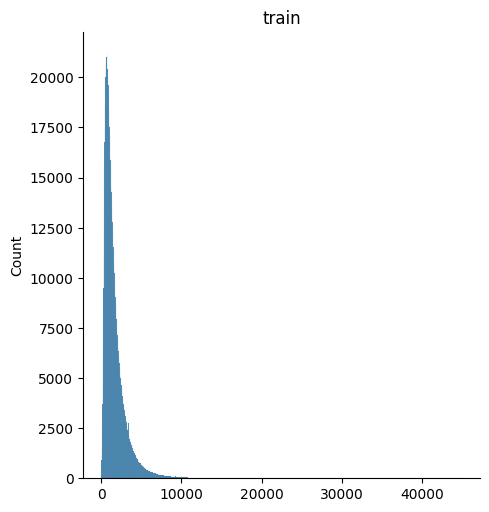

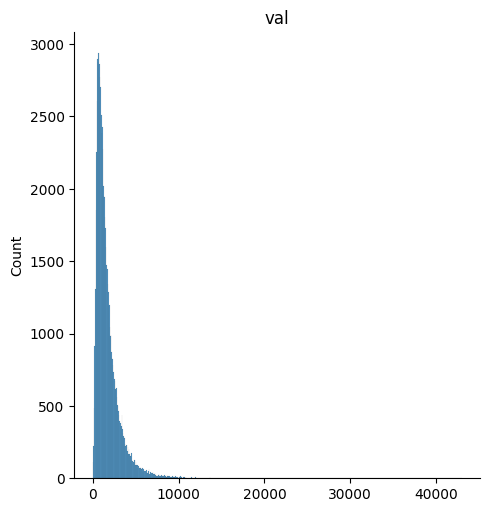

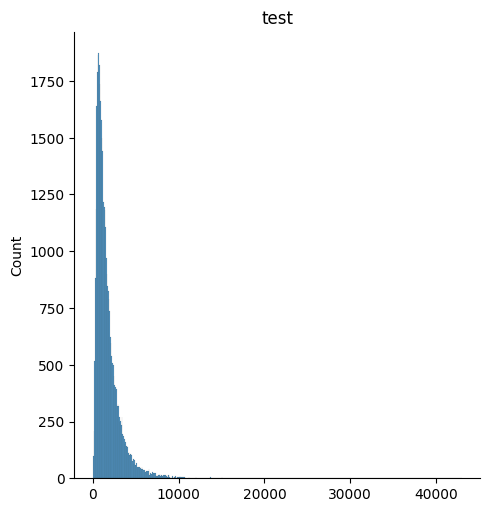

In [ ]:
for key, value in corpus.items():
    string_lengths = [len(string) for string in value['document']]
    sns.displot(string_lengths)
    plt.title(key)

### Number of emojis

### Number of sentences

In [158]:
for key, value in corpus.items():
    print(f"{key} - sentenctes per document:")
    sentences = value['ext_labels'].str.len()
    print(sentences.describe().apply("{0:.0f}".format))

train - sentenctes per document:
count    1555030
mean          16
std           15
min            1
25%            7
50%           11
75%           19
max          976
Name: ext_labels, dtype: object
val - sentenctes per document:
count    80747
mean        16
std         15
min          1
25%          7
50%         12
75%         20
max        493
Name: ext_labels, dtype: object
test - sentenctes per document:
count    40413
mean        16
std         16
min          1
25%          7
50%         12
75%         20
max        493
Name: ext_labels, dtype: object


### Number of words

Le principali statistiche riguardo il numero di parole per post

In [ ]:
for key, value in corpus.items():
    if (key != "train"):
        print(f"{key.upper()} - words stats")
        # Calcola il numero di parole inglesi in ogni stringa contenuta in 'document'
        english_word_counts = []
        for string in value['document']:
            # Divide la stringa in parole
            words = nltk.word_tokenize(string)
            # Conta solo le parole che non sono stopwords
            english_word_counts.append(len([word for word in words if word.lower() not in stop_words_en]))

        # Utilizza displot di seaborn per plottare la distribuzione del numero di parole inglesi
        # sns.displot(english_word_counts)
        
        stats = statistics.describe(english_word_counts)

        # Stampa le statistiche
        print("Number of elements:", stats.n)
        print("Min:", stats.minmax[0])
        print("Max:", stats.minmax[1])
        print("Mean:", stats.mean)
        print("Median:", stats.median)
        print("Standard deviation:", stats.stdev)
        print("First quartile:", stats.quartiles[0])
        print("Third quartile:", stats.quartiles[2])

### Number of word per document

# 2. Data Cleaning

## 2.1 Duplicati

Assenza duplicati in id e documenti

In [71]:
# exploring train, val and test documents
# train["document"][0][1:200]

print("id")
print("train:" + str(len(train['id'].unique())) + "/" + str(train.shape[0]))
print("val:" + str(len(val['id'].unique())) + "/" + str(val.shape[0]))
print("test:" + str(len(test['id'].unique())) + "/" + str(test.shape[0]))

print("document")
print("train:" + str(len(train['document'].unique())) + "/" + str(train.shape[0]))
print("val:" + str(len(val['document'].unique())) + "/" + str(val.shape[0]))
print("test:" + str(len(test['document'].unique())) + "/" + str(test.shape[0]))


id
train:1590132/1590132
val:80967/80967
test:40486/40486
document
train:1555030/1590132
val:80747/80967
test:40413/40486


Possibile presenza di duplicati in `document`

In [107]:
for key, value in corpus.items():
    count = value.duplicated(subset = ["document"]).sum()
    print(f"{key} - number of duplicated documents:{count}/{value.shape[0]}")

train - number of duplicated documents:0/1555030
val - number of duplicated documents:0/80747
test - number of duplicated documents:0/40413


In [103]:
import random

for key, value in corpus.items():
    print("key")
    # generate a random start index
    duplicate = value[value.duplicated(subset = ["document"])][['document', 'id']]

    # printa radomici
    #start_index = random.randint(0, len(duplicate_test) - 5)
    #duplicate_test.iloc[start_index:start_index+5]

    df_grouped = duplicate.groupby('document').size().reset_index(name='count')
    df_sorted = df_grouped.sort_values(by='count', ascending=False)
    print(df_sorted.head(5))

key
                                                document  count
5760   hey there , i 'm a bot and something you said ...    959
26242  your post has been removed for the following r...    477
26243  your post has been temporarily removed for the...    116
70     # let 's make a plan !</s><s> this week 's kic...    113
2784   basically it goes a little like this ... i bou...    106
key
                                              document  count
37   hey there , i 'm a bot and something you said ...     43
121  your post has been removed for the following r...     24
20   basically it goes a little like this ... i bou...      5
31   heads up , there are troubling reports of pack...      4
122  your post has been temporarily removed for the...      4
key
                                             document  count
14  hey there , i 'm a bot and something you said ...     22
37  your post has been removed for the following r...      9
3   ** hello , my name is rene i m a professional

Sembra che questi duplicati siano post ricorrenti / messaggi di bot / post automatici (tipo presentazione, rimozione post):
- Procedo alla rimozione

In [108]:
for key, value in corpus.items():
    # remove duplicates from train, val and test
    value.drop_duplicates(subset = ["document"], inplace=True)
    
for key, value in corpus.items():
    count = value.duplicated(subset = ["document"]).sum()
    print(f"{key} - number of duplicated documents:{count}/{value.shape[0]}")

train - number of duplicated documents:0/1555030
val - number of duplicated documents:0/80747
test - number of duplicated documents:0/40413


## 2.2 Missing Values

Null values

In [110]:
for key, value in corpus.items():
    # print number of null values in columns "id" and "document"
    print(f"{key} - number of null values in columns id and document:")
    print(value.isnull().sum())

train - number of null values in columns id and document:
id            0
document      0
summary       0
ext_labels    0
rg_labels     0
dtype: int64
val - number of null values in columns id and document:
id            0
document      0
summary       0
ext_labels    0
rg_labels     0
dtype: int64
test - number of null values in columns id and document:
id            0
document      0
summary       0
ext_labels    0
rg_labels     0
dtype: int64


# 3. Preprocessing

## 3.1 Sentences Splitting

Ricompongo le frasi trasformando le stringhe in liste di stringhe

In [146]:
# test_df = test.copy()
# def split_string(string):
#     return string.split("</s><s>")

# test_df["document"] = test_df["document"].apply(split_string)

# print(test_df['document'][0])
# type(test_df['document'][0])





In [153]:
def split_string(string):
    return string.split("</s><s>")

for key, value in corpus.items():
    value["document"] = value["document"].apply(split_string)

## 3.2 Normalization / Spelling Correction

### 3.2.1 Case Folding

In [ ]:
def to_lower(phrase):
  phrase = phrase.lower()
  return phrase

### Excessive Whitespaces Removal

### Emoji Removal

In [ ]:
def remove_emoji(phrase):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', phrase)

### Numbers Removal

In [ ]:
def rimozione_numbers(phrase):
  removed_numbers=re.sub(r'\d+', '',phrase)
  return phrase

### Expansion of contractions

In [ ]:
def expand_eng_contradictions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### HTML Tags Removal

In [ ]:
def remove_html_tags(sentence):
    pattern = re.compile("<.*?>") 
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

def remove_html_entities(sentence):
    pattern = re.compile("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}")
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

### Formatting chars removal

### URL Removal

In [ ]:
def remove_urls(sentence):
    http_pattern = re.compile(r"http\S+") 
    cleaned_sentence = re.sub(http_pattern,'',sentence).strip()
    www_pattern = re.compile(r"www\S+") 
    cleaned_sentence = re.sub(www_pattern,'',cleaned_sentence)
    return cleaned_sentence

### Tag/Hashtag/Channeltag/Userstag Removal

### Removal of words with 3 or more repeated characters within them

In [ ]:
def remove_words_with_repeated_characters(sentence): 
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    cleaned_text  = re.sub(pattern,' ',sentence)
    return (cleaned_text)

### Spelling mistakes Removal

### Removal of punctuation and special characters

In [ ]:
def remove_special_characters_punctuations(sentence):
    pattern = re.compile("[^a-zA-Z]+") 
    cleaned_text  = re.sub(pattern,' ',sentence).strip()
    return cleaned_text

# oppure
# Rimuovo caratteri non alfa numerici
# noalfa_sentence = [w for w in word_tokenize(lower_sentence) if (w.isalpha() == True)]

### Applicazione

1. Usa apply per applicare la macrofunzione agli elementi singoli
2. Usa map per applicare le singole funzioni agli elementi della lista

In [ ]:
def funzione_finale_normalizzazione(text):
  text = to_lower(text)
  text = remove_emoji(text)
  text = rimozione_numbers(text)
  text = expand_eng_contradictions(text)
  text = remove_html_tags(text)
  text = remove_html_entities(text)
  text = remove_urls(text)
  text = remove_words_with_repeated_characters(text)
  text = remove_special_characters_punctuations(text)
  text = text.lower()
  return text

In [ ]:
df_normalized = food_reviews_df_no_duplicates
df_normalized['Text_normalized'] = food_reviews_df_no_duplicates['Text'].apply(funzione_finale_normalizzazione)